## Minimal test of XyloSamna with power measurement
- Deploying a dummy network on Xylo a3 


In [1]:
import samna
print(f'Samna version {samna.__version__}')

import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns65302 import config_from_specification as a3_config_from, mapper as a3_mapper, XyloSamna as a3_XyloSamna, XyloMonitor as a3_XyloMonitor

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

Samna version 0.39.6.0


### Build a Dummy network 

In [2]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 8)),
    LIF(8),
)

### Create a simple spiking input 


In [3]:
import matplotlib.pyplot as plt
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probability

301


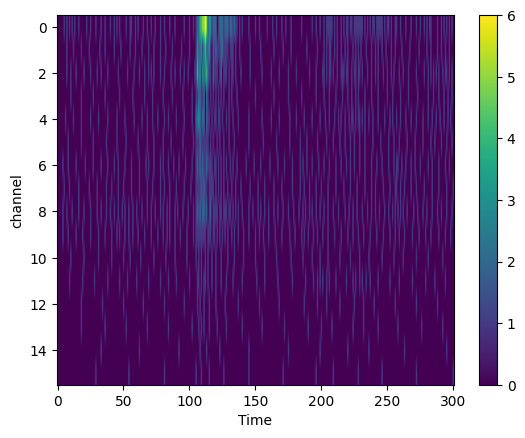

In [4]:
# use another set of data
input_data0 = np.load("/home/vleite/Downloads/rare_sound_3_second_samples_afe.npy", allow_pickle=True).item()['data'][7]
print(len(input_data0))

plt.figure()
plt.imshow(input_data0.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

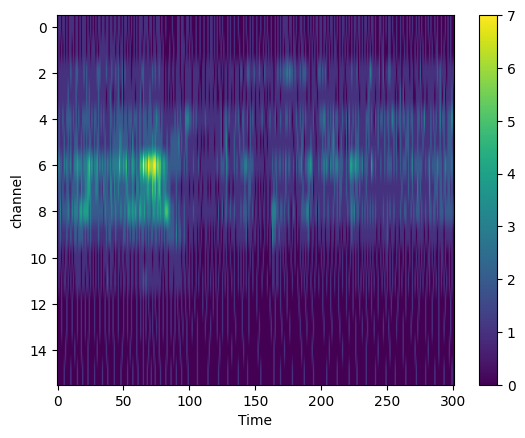

In [5]:
# use another set of data
input_data1 = np.load("/home/vleite/Downloads/rare_sound_3_second_samples_afe.npy", allow_pickle=True).item()['data'][12]

plt.figure()
plt.imshow(input_data1.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

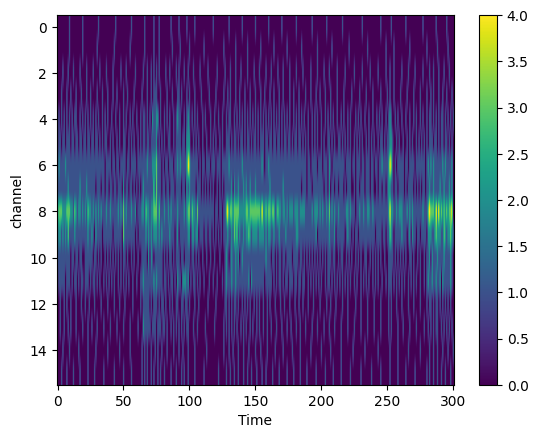

In [6]:
# use another set of data
input_data2 = np.load("/home/vleite/Downloads/rare_sound_3_second_samples_afe.npy", allow_pickle=True).item()['data'][20]

plt.figure()
plt.imshow(input_data2.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

### Detecting Xylos

In [7]:
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()

xa3_node = ""
for version, xylo in zip(xylo_versions, xylo_hdks):
    if version == "syns65302":
        xa3_node = xylo

print(xa3_node) if xa3_node else print("no XyloAudio 3 was found")

The connected Xylo HDK contains a XyloAudio 3. Importing `rockpool.devices.xylo.syns65302`


### Map it to Xylo a3
- and verifying the weights

In [8]:
if xa3_node:
    spec = a3_mapper(net.as_graph())
    Q_spec = spec
    Q_spec.update(channel_quantize(**Q_spec))
    a3_config, is_valid, msg = a3_config_from(**Q_spec)
    
    if not is_valid:
        print(msg)

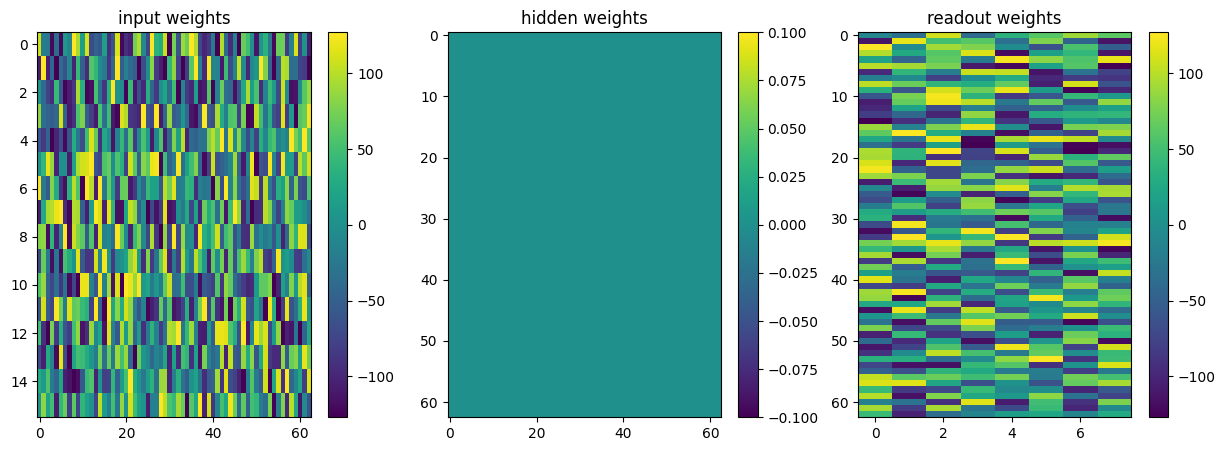

In [9]:
if xa3_node:
    w_in = a3_config.input.weights
    w_hid = a3_config.hidden.weights
    w_out = a3_config.readout.weights
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
    plt.subplot(132)
    plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
    plt.subplot(133)
    plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

In [10]:
a3_config.operation_mode                                        = samna.xyloAudio3.OperationMode.AcceleratedTime

In [11]:
if xa3_node:
    dt = 0.01
    Xmod = a3_XyloSamna(xa3_node, a3_config, dt = dt, record = True, power_frequency=5)

In [12]:
out, _, rec = Xmod.evolve(input_data0,  record_power = False)

In [13]:
out, _, rec = Xmod.evolve(input_data1, record_power = False)

# print(len(rec['io_power']))
# print(len(rec['analog_power']))
# print(len(rec['digital_power']))

# io_power = np.mean(rec['io_power'])
# analog = np.mean(rec['analog_power'])
# digital = np.mean(rec['digital_power'])

# print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1000:.1f} mW\nAFE core:\t{analog * 1000:.1f} mW\nSNN core logic:\t{digital*1000:.1f} mW')

In [14]:
out, _, rec = Xmod.evolve(input_data2, record_power = False)

print(len(input_data2))

# print(len(rec['io_power']))
# print(len(rec['analog_power']))
# print(len(rec['digital_power']))

# io_power = np.mean(rec['io_power'])
# analog = np.mean(rec['analog_power'])
# digital = np.mean(rec['digital_power'])

# print(f'XyloAudio 3\nAll IO:\t\t{io_power * 1000:.1f} mW\nAFE core:\t{analog * 1000:.1f} mW\nSNN core logic:\t{digital*1000:.1f} mW')

301


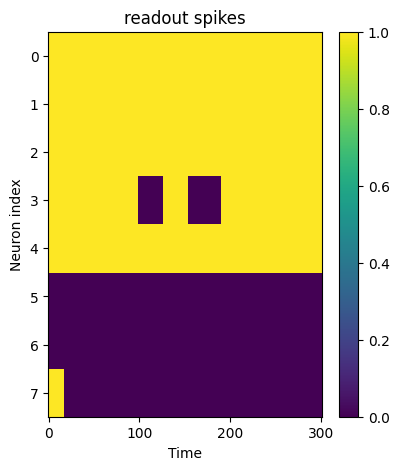

In [15]:
if xa3_node:
    plt.figure(figsize=(15,5))
    plt.subplot(131), plt.imshow(out.T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
